In [976]:
import urllib.request
import re
import json
import matplotlib.pyplot as plt
import math
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from datetime import date
import copy
import os
%matplotlib inline

In [604]:
site = 'https://vk.com/meduzaproject' # vk-public meduza
# какие-то посты в нём дублируются с той же подписью

In [605]:
title = site.split('/')[-1]

In [606]:
key = "099d9696099d9696099d96967a09ffdc410099d099d96965357a63d615a97ea025c229e" # сервисный ключ доступа

In [607]:
req = urllib.request.Request('https://api.vk.com/method/wall.get?domain={}&count=1&filter=all&v=5.74&access_token={}'.format(title, key))
response = urllib.request.urlopen(req)
result = response.read().decode('utf-8')
result = json.loads(result)

In [611]:
total = result['response']['count'] # общее число записей в сообществе
owner_id = result['response']['items'][0]['from_id'] # определяем owner_id по названию public-а
post_id = result['response']['items'][0]['id'] # post_id самого верхнего комментария
w = 20000 # обоудйсь скачиванием первых 20000 постов
total, owner_id, post_id # на момент скачивания общее кол-во постов было именно таким

(32310, -76982440, 1898311)

In [620]:
offsets = [str(i * 100) for i in range(w // 100)] # заведём массив с нужным числом отсутпов

In [639]:
len(offsets)

200

In [674]:
n = 100
posts = [] # массив для записи постов
post_ids = [] # массив для записи id-ников постов, чтобы потом получить комментарии к ним

In [ ]:
# заполняем массивы
k = 0
for offset in offsets:
    req = urllib.request.Request('https://api.vk.com/method/wall.get?domain={}&count={}&offset={}&filter=all&v=5.74&access_token={}'.format(title, n, offset, key))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    result = json.loads(result)
    for i in range(n):
        print(result['response']['items'][i]['id'], k, len(posts), len(post_ids))
        k += 1
        post_ids.append(result['response']['items'][i]['id'])
        posts.append(result['response']['items'][i]['text'])

In [691]:
comments = [] # массив для комментариев к постам
id_commentators = [] # массив для id-ников комментаторов, чтобы затем собрать социолингвистическую информацию про них

In [ ]:
for i, post_id in enumerate(post_ids):
    print(post_id, i)
    req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id={}&post_id={}&count=1&v=5.74&access_token={}'.format(owner_id, post_id, key))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    result = json.loads(result)
    total = result['response']['count'] # общее количество комментариев
    comments.append([]) # в этот массив будем класть комментарии
    id_commentators.append([]) # а сюда id-ники комментаторов
    for j, offset in enumerate([i * 100 for i in range(math.ceil(total / 100))]): # подбираем нужное кол-во отступов по кол-ву комментариев к посту
        req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id={}&post_id={}&offset={}&count={}&v=5.74&access_token={}'.format(owner_id, post_id, offset, n, key)) # скачиваем сразу по n=100 комментариев
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        result = json.loads(result)
        for comment in result['response']['items']:
            comments[i].append(comment['text'])
            id_commentators[i].append(comment['from_id'])

In [715]:
comment_lens = [] # массив для средней длины комментов к посту
post_lens = [] # массив для длин постов

In [ ]:
for i in range(len(comments)):
    num_ = 0
    sum_ = 0
    for j, comment in enumerate(comments[i]):
        comments[i][j] = re.sub('[.,;:?!@#$%^&()_+=—]', '', comment) # очищаем от знаков препинания, чтобы не ошибиться с кол-м слов
        num_ += 1
        sum_ += len(comments[i][j].split())
    if num_ != 0:
        comment_lens.append(sum_ / num_)
    else: # бывают комменты с картинкой => без слов
        comment_lens.append(0)
    posts[i] = re.sub('[.,;:?!@#$%^&()_+=—]', '', posts[i]) # очищаем от знаков препинания, чтобы не ошибиться с кол-м слов
    post_lens.append(len(posts[i].split()))
    print(i)

In [722]:
# проведём построенную с помощью линейной регрессии прямую, чтобы оценить тренд
LR = lm.LinearRegression()
LR.fit(np.array(post_lens).reshape(len(post_lens), 1), np.array(comment_lens).reshape(len(comment_lens), 1))
y_pred = LR.predict(np.array(post_lens).reshape(len(post_lens), 1))

In [723]:
# mean squared error: насколько хорошо приближает прямая данные
print('Значение MSE:', MSE(y_pred, np.array(comment_lens).reshape(len(comment_lens), 1)))

Значение MSE: 73.5088170137


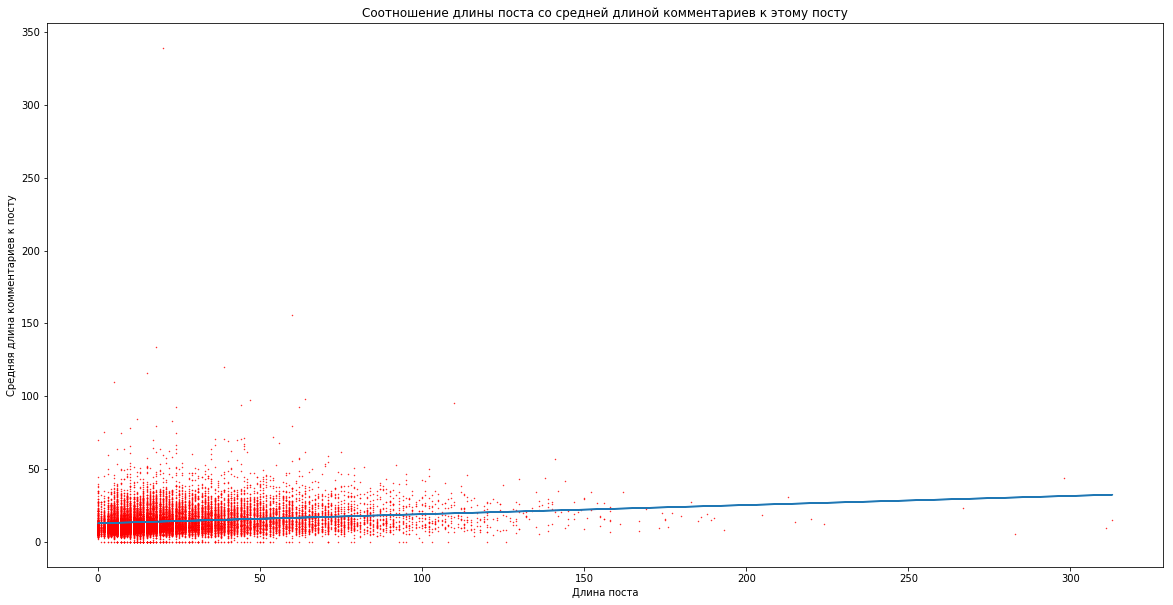

In [727]:
# Чем больше пост, тем длиннее комментарии? Логично.
plt.figure(figsize=(20,10))
plt.scatter(post_lens, comment_lens, s=0.2, c='r')
plt.plot(np.array(post_lens).reshape(len(post_lens), 1), y_pred)
plt.title('Соотношение длины поста со средней длиной комментариев к этому посту')
plt.xlabel('Длина поста')
plt.ylabel('Средняя длина комментариев к посту')
plt.savefig('lengths.png')
plt.show()

In [731]:
# пост с максимальным количеством комментариев
# это пост из далёкого прошлого о выходе на свободе насильника Дианы Шурыгиной
max = 0
j = 0
for i, comment in enumerate(comments):
    if len(comment) > max:
        max = len(comment)
        j = i
print(max)
print(posts[j])

3866
Когда именно Сергей Семенов выйдет на свободу пока не уточняется


In [740]:
# собираем социо-лингвистическую информацию про комментаторов
# на meduza.io нельзя постить своё, поэтому рассматриваем только комментарии пользователей
ages = dict() # массив соотношения возрастов и длин комментов
cities = dict() # массив соотношения городов и длин комментов

Поскольку очень долго обкачивать, скачаю только данные первой тысячи постов

In [ ]:
k = 0 # индекс поста
for i, ids in enumerate(id_commentators[:1000]): # ограничение на 1000 постов
    num = 0 # внутренний индекс комментария
    ids = [str(id_) for id_ in ids]
    for id_ in ids:
        # если родной город человека и город, указанный в контактах, не совпадают, то я считаю, что человек связан с 2 городами
        fl = 0 # чтобы два раза не считать совпадающие родной город и город в контактах
        req = urllib.request.Request('https://api.vk.com/method/users.get?user_ids={}&fields={}&v=5.74&access_token={}'.format(id_, 'bdate,city,home_town', key))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        result = json.loads(result)
        print(result, i)
        if 'response' not in result: # к примеру, комменты может оставлять сообщество https://vk.com/tg_me, что вызывает ошибку
            continue
        elem = result['response'][0]
        
        if 'city' in elem:
            fl = 1 # city указан
            tmp = elem['city']['title']
            if tmp not in cities: # заполняем словарь cities
                cities[tmp] = [len(comments[i][num].split())]
            else:
                cities[tmp].append(len(comments[i][num].split()))
                
        if 'home_town' in elem and elem['home_town'] != '': # часто встречается пустое поле ('') вместо названия
            if fl == 1 and tmp == elem['home_town']: # city есть + совпадает с home_town
                pass
            else:
                tmp = elem['home_town']
                if tmp not in cities: # заполняем словарь cities
                    cities[tmp] = [len(comments[i][num].split())] # записываем также в cities
                else:
                    cities[tmp].append(len(comments[i][num].split()))
                
        if 'bdate' in elem:
            a = list(map(int, elem['bdate'].split('.')))
            if len(a) == 3:
                today = date.today()
                age_ = today.year - a[2] - ((today.month, today.day) < (a[1], a[0])) # узнаём возраст
                if age_ not in ages: # заполняем словарь ages
                    ages[age_] = [len(comments[i][num].split())]
                else:
                    ages[age_].append(len(comments[i][num].split()))
        
        num += 1

In [ ]:
for key in cities.keys(): # далее копирую это в файл replace.txt и заменяю неправильное (типа Крск) и удаляю некорректное (типа Heaven)
    print(key + '\t')

In [799]:
dct = dict()
with open('replace.txt', 'r', encoding='utf-8') as f: # считываю из файла то, что нужно удалить или изменить
    for line in f.readlines():
        a = line.split('\t')
        if a[1] != '\n':
            dct[a[0]] = a[1].strip()

In [810]:
for key, value in sorted(cities.items()):
    if key in dct:
        if dct[key] == '-': # человек написал что-то некорректное (всякие игровые миры и прочее)
            cities.pop(key)
        else:
            if dct[key] in cities: # если уже есть правильный вариант, добавляю данные в него
                cities[dct[key]].extend(value)
            else:
                cities[dct[key]] = value # добавляю правильный вариант
            cities.pop(key) # удаляю старый вариант

In [872]:
cities.pop('\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Милый') # почему-то не удалилось ранее

[6]

In [874]:
cities.pop('') # и это тоже

[76, 10, 2]

In [ ]:
sorted(cities.keys()) # для английских наименований нет русского эквивалента (очень редкие города)

In [877]:
for key, value in sorted(cities.items()): # случаи типа "Санкт-Петербург " и "Санкт-Петербург" относятся к одному и тому же
    if key != key.strip(): # наш случай
        if key.strip() in cities:
            cities[key.strip()].extend(value)
        else:
            cities[key.strip()] = value
        cities.pop(key) # удаляем старый вариант

In [879]:
cities['Старый Оскол'].extend(cities['Старый Оскло']) # исправляю ошибки
cities.pop('Старый Оскло')

[8, 5, 7, 9, 20, 32, 4, 6]

In [883]:
# Cаяногорск (кто-то написал первую C английскую), так что исправляем
cities['Саяногорск'].extend(cities['Cаяногорск'])
cities.pop('Cаяногорск')

[28]

In [885]:
# Cаратов (аналогично)
cities['Саратов'].extend(cities['Cаратов'])
cities.pop('Cаратов')

[7, 6]

In [815]:
ages_ = copy.deepcopy(ages) # чтобы сохранить предыдущий массив (используем deepcopy, чтобы не затереть ages)

In [822]:
for key, value in sorted(ages_.items()):
    ages_[key] = np.mean(ages_[key]) # заменяем в новом словаре на среднюю длину комментария для данного возраста

Т.к. у меня паблик, в котором пользователи не могут публиковать свои посты, то рассматриваю только комментарии

In [1009]:
keys = np.array(list(ages_.keys())).reshape(len(ages_.keys()), 1)

In [843]:
# аналогично строю прямую, отображающую тенденцию
LR = lm.LinearRegression()
LR.fit(keys, np.array(list(ages_.values())).reshape(len(ages_.values()), 1))
y_pred = LR.predict(keys)

In [845]:
# приближение
print('Значение MSE:', MSE(y_pred, np.array(list(ages_.values())).reshape(len(ages_.values()), 1)))

Значение MSE: 29.1026031621


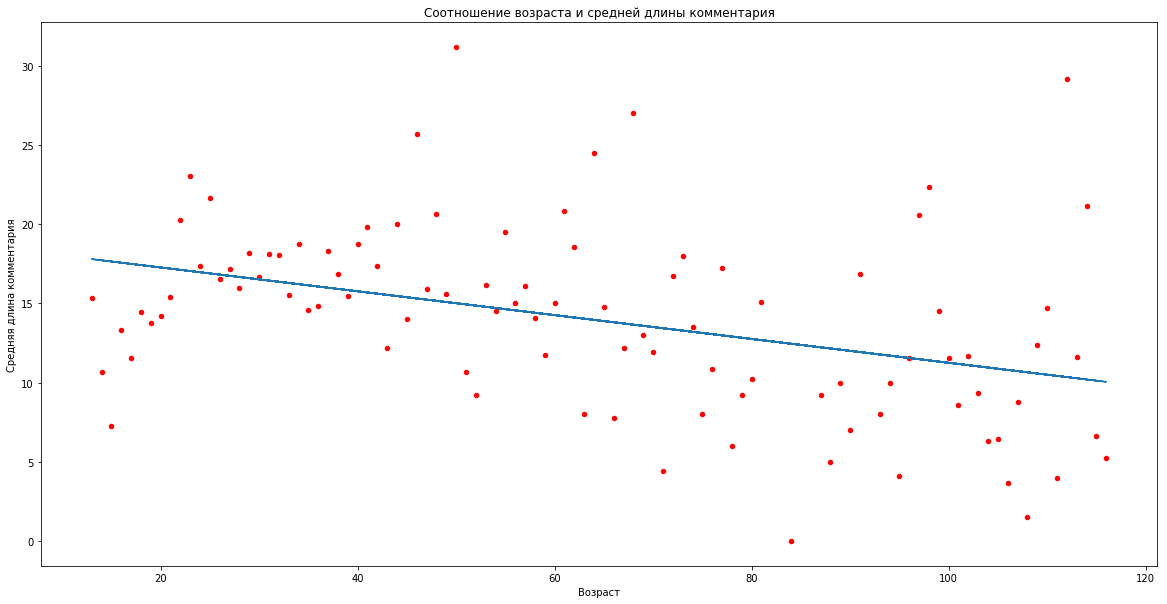

In [1011]:
# Чем старше, тем меньше длина комментария? Не интуитивно.
plt.figure(figsize=(20,10))
plt.scatter(ages_.keys(), ages_.values(), s=20, c='r')
plt.plot(keys, y_pred)
plt.title('Соотношение возраста и средней длины комментария')
plt.xlabel('Возраст')
plt.ylabel('Средняя длина комментария')
plt.savefig('ages.png')
plt.show()

In [991]:
cities_ = copy.deepcopy(cities) # чтобы сохранить предыдущий массив

In [992]:
for key, value in sorted(cities_.items()):
    cities_[key] = np.mean(cities_[key])

In [1012]:
len(cities_)

1215

In [1013]:
keys = cities_.keys()

Отобразим все имеющиеся города (можно было бы отсортировать по алфавиту, но не вижу пользы):

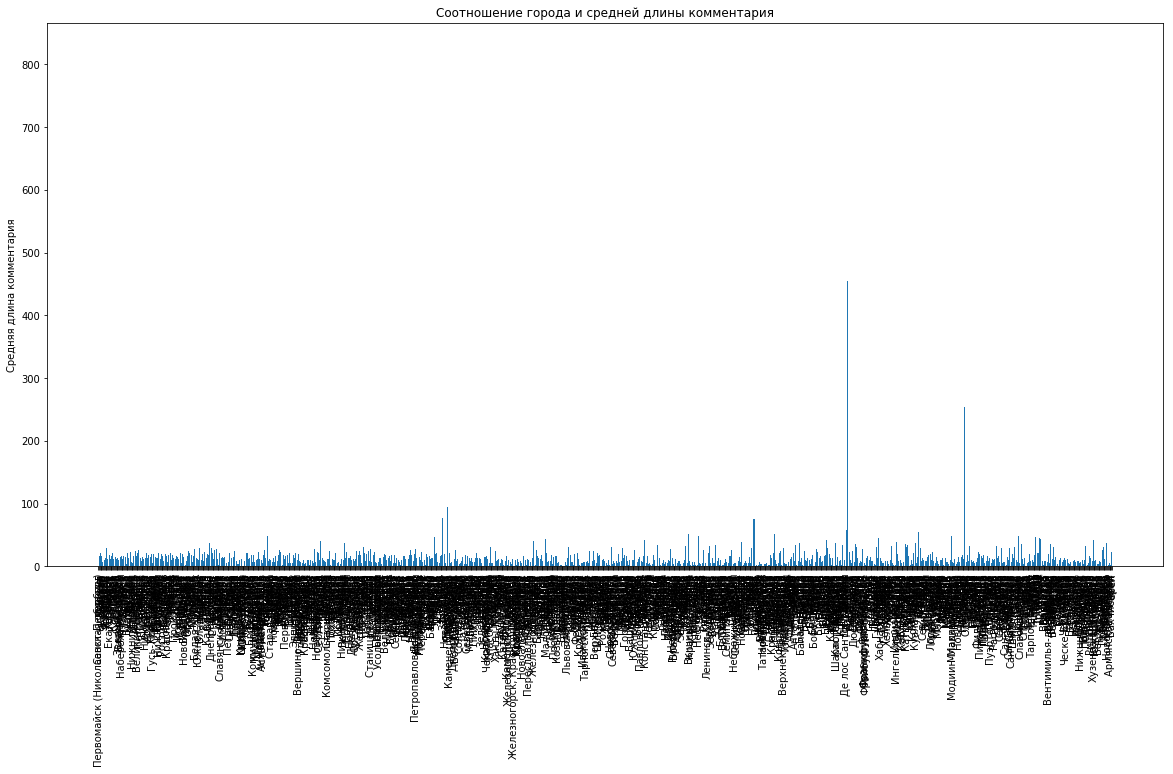

In [1014]:
plt.figure(figsize=(20,10))
plt.bar(range(len(keys)), cities_.values())
plt.title('Соотношение города и средней длины комментария')
# plt.xlabel('Город')
plt.xticks(range(len(keys)), list(keys), rotation=90)
plt.ylabel('Средняя длина комментария')
plt.savefig('cities_all.png')
plt.show()

Это не очень информативно, так что наложим ограничение: необходимо, чтобы из одного города было хотя бы 4 комментария (возможно, что от одного человека)

In [1015]:
cities__ = dict()
for key, value in cities.items():
    if len(value) > 3:
        cities__[key] = np.mean(value)

In [1016]:
len(cities__)

586

In [1017]:
keys = cities__.keys()

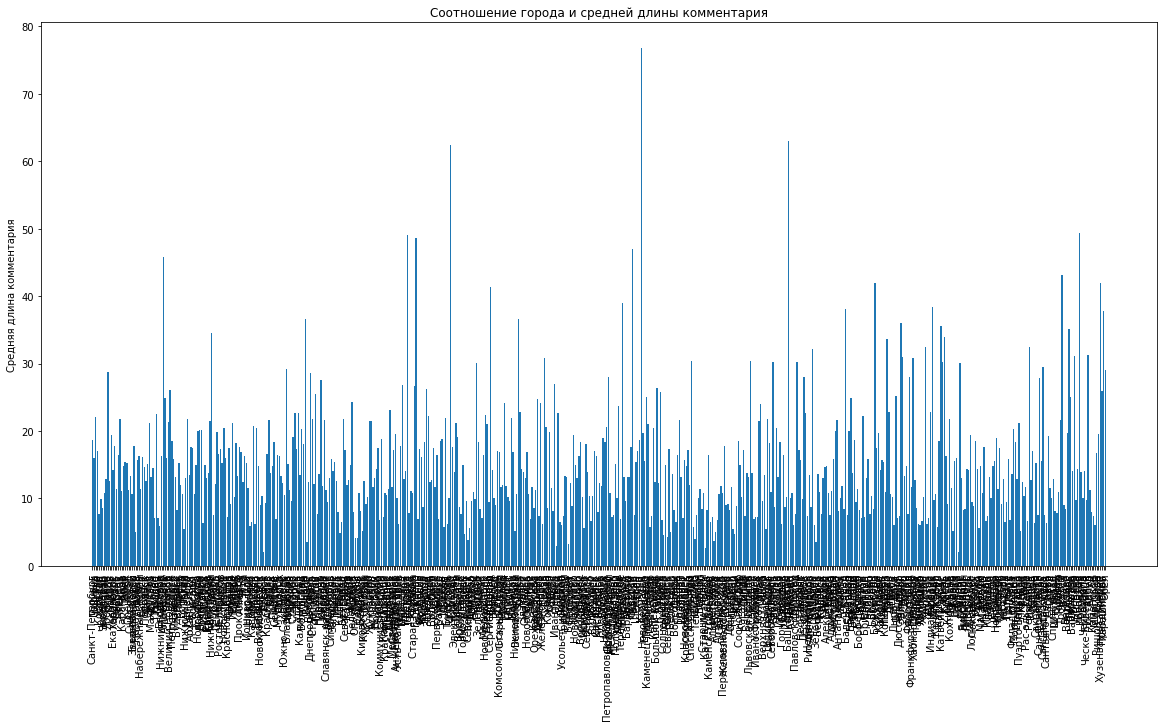

In [1018]:
plt.figure(figsize=(20,10))
plt.bar(range(len(keys)), cities__.values())
plt.title('Соотношение города и средней длины комментария')
# plt.xlabel('Город')
plt.xticks(range(len(keys)), list(keys), rotation=90)
plt.ylabel('Средняя длина комментария')
plt.savefig('cities_3.png')
plt.show()

Это тоже не очень информативно, так что увеличим порог до 15

In [1019]:
cities__ = dict()
for key, value in cities.items():
    if len(value) > 15:
        cities__[key] = np.mean(value)

In [1020]:
len(cities__)

248

In [1021]:
keys = cities__.keys()

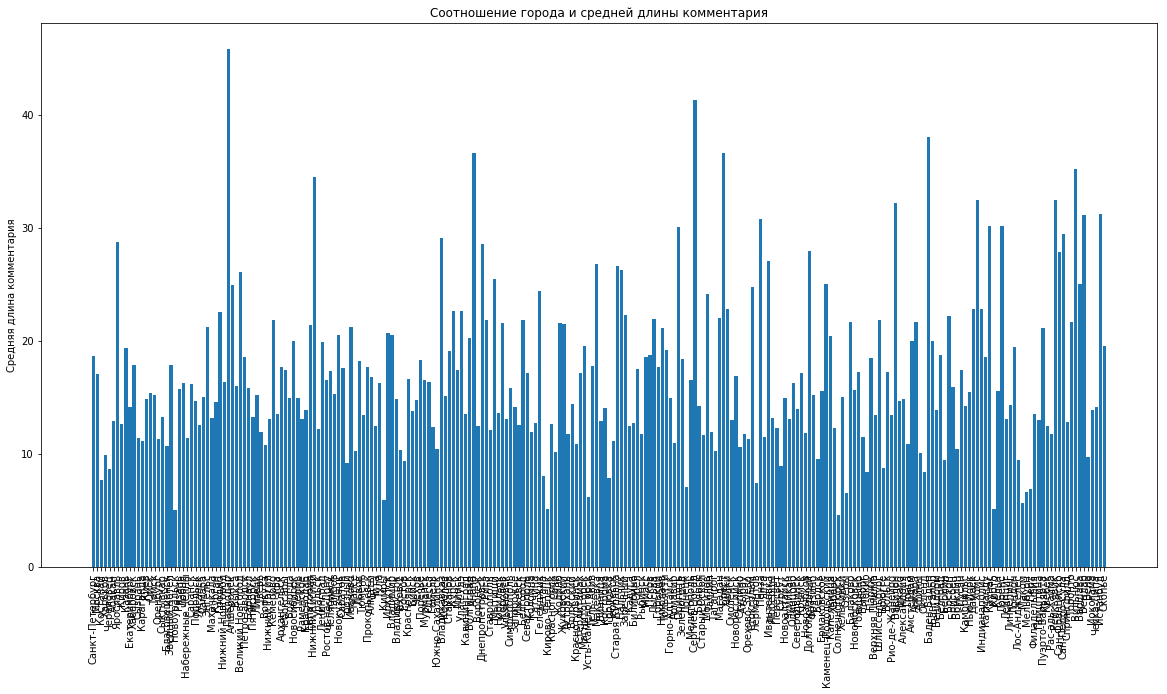

In [1022]:
plt.figure(figsize=(20,10))
plt.bar(range(len(keys)), cities__.values())
plt.title('Соотношение города и средней длины комментария')
# plt.xlabel('Город')
plt.xticks(range(len(keys)), list(keys), rotation=90)
plt.ylabel('Средняя длина комментария')
plt.savefig('cities_15.png')
plt.show()

Увеличим порог до 60

In [1023]:
cities__ = dict()
for key, value in cities.items():
    if len(value) > 60:
        cities__[key] = np.mean(value)

In [1024]:
len(cities__)

102

In [1025]:
keys = cities__.keys()

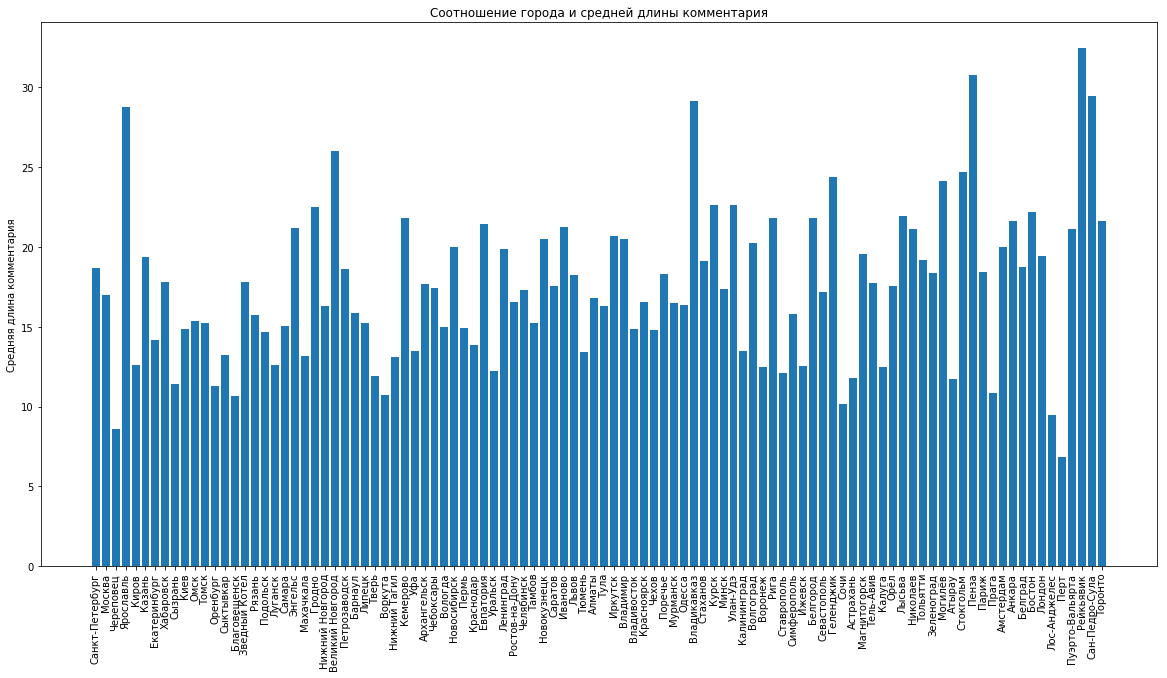

In [1026]:
plt.figure(figsize=(20,10))
plt.bar(range(len(keys)), cities__.values())
plt.title('Соотношение города и средней длины комментария')
# plt.xlabel('Город')
plt.xticks(range(len(keys)), list(keys), rotation=90)
plt.ylabel('Средняя длина комментария')
plt.savefig('cities_60.png')
plt.show()

На этом я остановлюсь

In [987]:
with open('posts.txt', 'w', encoding='utf-8') as f:
    for i, post in enumerate(posts):
        f.write(str(i+1) + '-й пост:\n' + post + '\n')

In [989]:
with open('comments.txt', 'w', encoding='utf-8') as f:
    for i, comments_ in enumerate(comments):
        f.write('Комментарии к ' + str(i+1) + '-му посту:\n')
        for j, comment in enumerate(comments_):
            f.write(str(j+1) + '-й комментарий:\n' + comment + '\n')
            f.write('\n')

In [990]:
with open('posts+comments.txt', 'w', encoding='utf-8') as f:
    for i, post in enumerate(posts):
        f.write(str(i+1) + '-й пост:\n' + post + '\n')
        f.write('Комментарии к ' + str(i+1) + '-му посту:\n')
        for j, comment in enumerate(comments[i]):
            f.write(str(j+1) + '-й комментарий:\n' + comment + '\n')
            f.write('\n')